# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

### Define functions

In [345]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [346]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [347]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What do the reference and rating numbers represent? (Hint: read the dataset documentation and write down the interpretation for each number).

In [348]:
# YOUR CODE HERE
'''1. 9 columns in the dataset.
   2. 1795 rows in the dataset.
   3. Column name: 'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin' 
   
   5. reference_number: "A value linked to when the review was entered in the database. Higher = more recent." 
      rating: "Expert rating for the bar"
      source: documentation in Kaggle'''
   

# 4. Number of unique values for each column 
for column in df.columns:
    unique_count = len(df[column].unique())
    print(f'Number of unique {column} values: {unique_count}')



Number of unique maker values: 414
Number of unique specific_origin values: 1038
Number of unique reference_number values: 440
Number of unique review_date values: 12
Number of unique cocoa_percent values: 45
Number of unique maker_location values: 58
Number of unique rating values: 13
Number of unique bean_type values: 39
Number of unique broad_origin values: 160


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you've familiarized yourself with the data a little bit, select a multiclass outcome you're interested in predicting. Note: the outcome should have <span style="color:chocolate">at least 3 classes</span>!

Intuition: conducting a multi-class classification on this chocolate dataset can be incredibly valuable for several reasons: customer preferences and personalization, market analysis, R&D, etc.

Your answer here: 
The model will be built using rating as the multiclass outcome variable. It is the expert rating and will be classified into 4 classes (class 1,2,3, and 4). Using the explanatory variables to predict the rating (with 4 classes) is the goal of this model. 


---
### Step 2: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 3:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features within the dataset and the chosen outcome;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

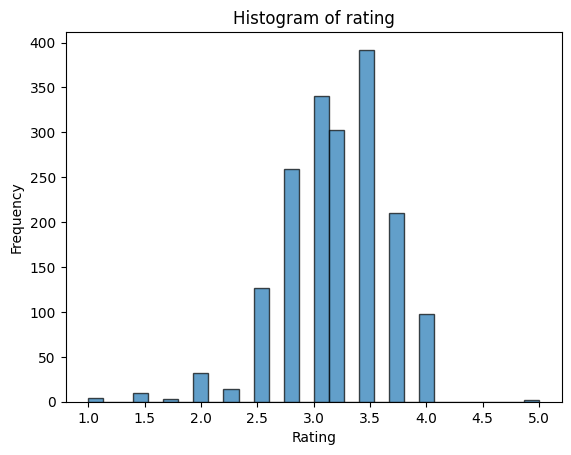

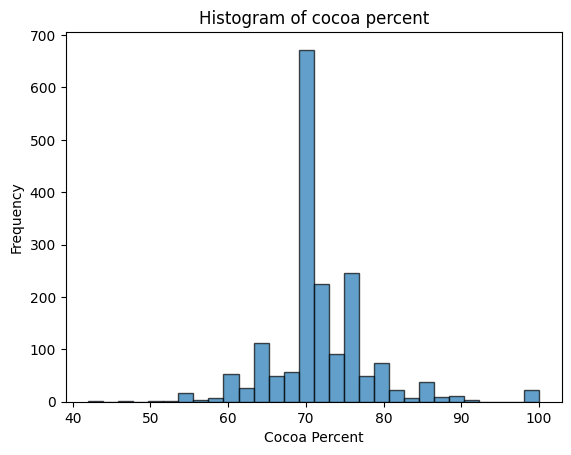

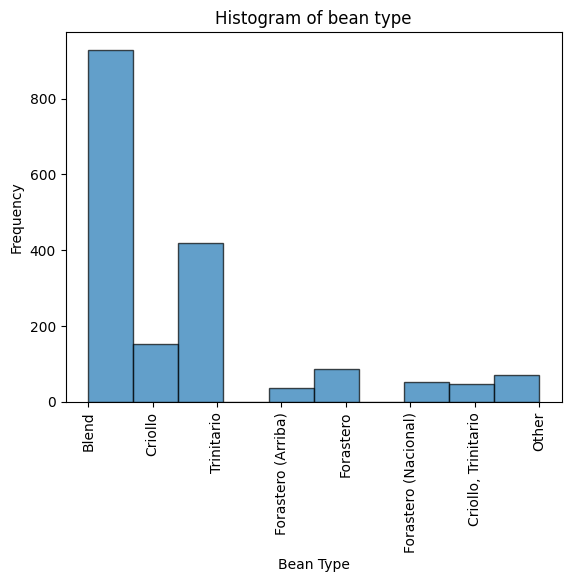

broad_origin
Other                 343
Venezuela             214
Ecuador               193
Dominican Republic    166
Peru                  165
                     ... 
Trinidad               33
Ghana                  33
Mexico                 30
Guatemala              28
Hawaii                 28
Name: count, Length: 20, dtype: int64


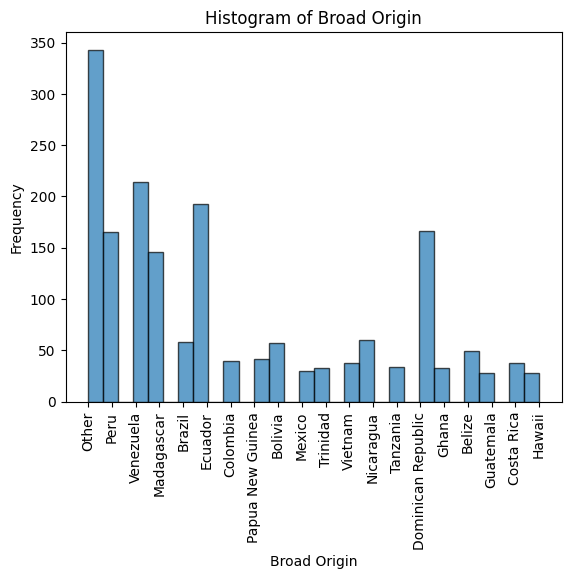

'Venezuela, Ecuador, Peru, Madagasker, and Dominican Republic are the major origins'

In [349]:
plt.hist(df['rating'],bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

'''From the rating histogram it can be seen that majority of the ratings are between 2.5 and 4, with 2.5 having the 
highest count/frequency. '''

plt.hist(df['cocoa_percent'],bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of cocoa percent')
plt.xlabel('Cocoa Percent')
plt.ylabel('Frequency')
plt.show()

'''The cocoa_percent histogram shows that the 70% cocoa is the most frequent one '''

# Get the count of each bean_type
bean_type_counts = df['bean_type'].value_counts()

other_bean_type = bean_type_counts[bean_type_counts<=10].index

#for counts less than 10, the label/name is replaced with "Other"
for bean_type in other_bean_type:
    df.loc[df['bean_type'] == bean_type, 'bean_type'] = 'Other'
    
plt.hist(df['bean_type'],bins=10, edgecolor='k', alpha=0.7)
plt.title('Histogram of bean type')
plt.xlabel('Bean Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
'''Bean type histogram reveals that blend type beans are the most frequent one and is about 50% of the total bean types.'''


# Get the count of each broad_origin
broad_origin_counts = df['broad_origin'].value_counts()

other_broad_origin = broad_origin_counts[broad_origin_counts<=20].index

#for counts less than and equal to 20, the label/name is replaced with "Other"
for broad_origin in other_broad_origin:
    df.loc[df['broad_origin'] == broad_origin, 'broad_origin'] = 'Other'
    
print(df['broad_origin'].value_counts())

plt.hist(df['broad_origin'],bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Broad Origin')
plt.xlabel('Broad Origin')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

'''Venezuela, Ecuador, Peru, Madagasker, and Dominican Republic are the major origins'''



---
### Step 3: Data preprocessing

### <span style="color:chocolate">Exercise 4:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Identify the features of interest;
2. Perform necessary cleaning on the features;
3. Reassess the outcome variable if desired (e.g., potentially reducing the number of classes, while ensuring a minimum of 3);
4. Shuffle the dataset;
5. Create training, validation, and test datasets using a 60/20/20 split;
6. Standardize the data;
7. Integrate any supplementary tasks deemed crucial for modeling, especially considering the chosen outcome variable.

In [350]:
# YOUR CODE HERE

#1. Features of interest: bean_type, cocoa_percent, broad_origin

# pd.set_option('display.max_rows', None)
pd.options.display.max_rows = 15


#2. Cleaning features
# Factorize the bean_type column
labels, unique = pd.factorize(df['bean_type'])

# Create a mapping dictionary
mapping_beans = {label: idx for idx, label in enumerate(unique)}

# Apply the mapping to the bean_type column
df['bean_type_mapped'] = labels


label_origin, unique = pd.factorize(df['broad_origin'])

# Create a mapping dictionary
mapping_origin = {label: idx for idx, label in enumerate(unique)}

# Apply the mapping to the bean_type column
df['broad_origin_mapped'] = label_origin

#3. Reducing the outcome variable to 4 classes. Hence, Creating 4 classes for ratings
def classify_rating(rating):
    if rating <= 2:
        return 3
    elif 2 < rating <= 3:
        return 2
    elif 3<rating < 4:
        return 1
    elif rating>=4:
        return 0
    else:
        return None  # Handle any unexpected values
    
df['rating'] = df['rating'].apply(lambda x: classify_rating(x))

#getting counts of the 4 rating class
rating_class_counts = df['rating'].value_counts().sort_index()
print(rating_class_counts)
print(df['rating'].unique())

#reducing the dataframe to keep only labels and features
df = df[['rating','bean_type_mapped','cocoa_percent', 'broad_origin_mapped']]
df.head()


rating
0    100
1    905
2    741
3     49
Name: count, dtype: int64
[1 2 0 3]


,rating,bean_type_mapped,cocoa_percent,broad_origin_mapped
0,1,0,63.00,0
1,2,0,70.00,0
2,2,0,70.00,0
3,1,0,70.00,0
4,1,0,70.00,1


In [351]:
from sklearn.model_selection import train_test_split
#4. Shuffling dataset

X = df[['bean_type_mapped', 'cocoa_percent','broad_origin_mapped']]
Y = df['rating']
shuffled_indices = np.random.permutation(range(len(Y)))

df = df.iloc[shuffled_indices].reset_index(drop=True)
print(df.head())

#5. Creating training, validation, and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=1234)

X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.25, random_state=1234)

print('Size of X_train', X_train.shape)
print('Size of Y_train', Y_train.shape)
print('Size of X_val', X_val.shape)
print('Size of Y_val', Y_val.shape)
print('Size of X_test', X_test.shape)
print('Size of Y_test', Y_test.shape)


#6. Standardizing data
from sklearn.preprocessing import StandardScaler

# Creating a StandardScaler instance
scaler = StandardScaler()

# Fitting the scaler on X_train and transform X_train, X_val, and X_test
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
X_val= scaler.transform(X_val)

# Fit the scaler on Y_train and transform Y_train, Y_val, and Y_test
# Y_train= scaler.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
# Y_val= scaler.transform(Y_val.values.reshape(-1, 1)).flatten()
# Y_test= scaler.transform(Y_test.values.reshape(-1, 1)).flatten()

print("All values of Y train:", Y_train)

print("All values of X train:", X_train)




   rating  bean_type_mapped  cocoa_percent  broad_origin_mapped
0       2                 0          60.00                    8
1       1                 0          74.00                   14
2       1                 0          75.00                    5
3       1                 0          70.00                    0
4       2                 0          73.00                   14
Size of X_train (1077, 3)
Size of Y_train (1077,)
Size of X_val (359, 3)
Size of Y_val (359,)
Size of X_test (359, 3)
Size of Y_test (359,)
All values of Y train: 408     2
244     0
15      2
884     2
1455    1
       ..
1575    2
1164    2
250     2
1084    2
607     2
Name: rating, Length: 1077, dtype: int64
All values of X train: [[ 0.947627    1.64777343 -0.15129329]
 [ 0.39950977  0.53479006 -0.50436562]
 [-0.69672468 -0.26019806 -1.0339741 ]
 ...
 [ 0.39950977 -0.26019806  1.79060449]
 [-0.69672468  0.53479006 -0.68090178]
 [-0.14860746 -0.57819331 -0.68090178]]


---
### Step 4: Exploratory data analysis (EDA) - cont'd

### <span style="color:chocolate">Exercise 5:</span> More plots (5 points)

Conduct any further exploratory data analysis (EDA) you believe necessary to validate the successful preprocessing of the data.

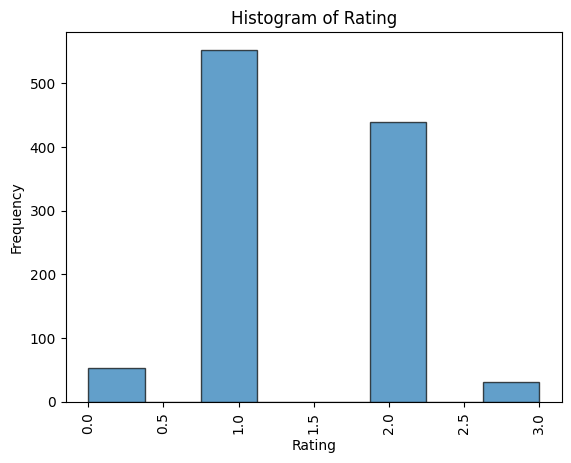

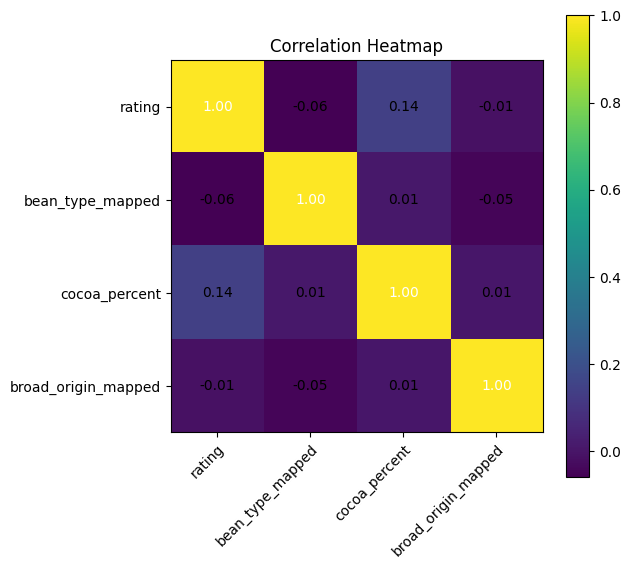

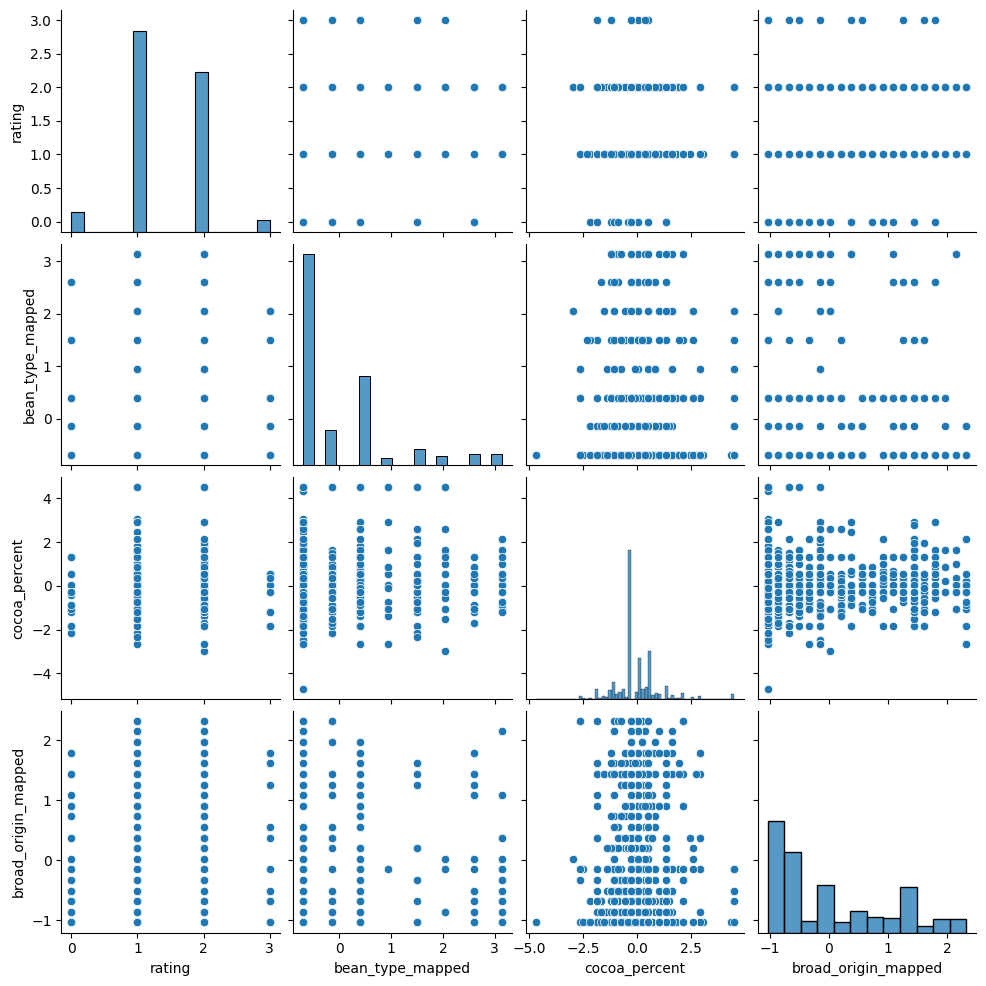

In [352]:
# YOUR CODE HERE

# Assemble a new dataframe for plotting
import matplotlib.pyplot as plt
df_train = pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)],
    axis=1
)
df_train.columns=[ 'rating', 'bean_type_mapped', 'cocoa_percent', 'broad_origin_mapped']

plt.hist(df_train['rating'],bins=8, edgecolor='k', alpha=0.7)
plt.title('Histogram of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

from mlxtend.plotting import heatmap
cm = df.corr().values


hm = heatmap(cm,row_names=df_train.columns, column_names=df_train.columns, figsize=(6,6))
plt.title('Correlation Heatmap')

sns.pairplot(df_train)
plt.show()

---
### Step 5: Modeling

### <span style="color:chocolate">Exercise 6:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [353]:
# YOUR CODE HERE

# Identify the majority class in the training set
majority_class = np.bincount(Y_train).argmax()

# Function to compute the cross-entropy loss
def ce_loss(preds, Y):
    epsilon = 1e-15  # Small constant for numerical stability
    preds = np.clip(preds, epsilon, 1 - epsilon)  # Clip predicted probabilities
    m = Y.shape[0]
    cross_entropy_values = - np.sum(Y * np.log(preds), axis=1)
    loss = np.sum(cross_entropy_values) / m
    return loss

# Majority class predictions for training data
majority_preds_train = np.full(Y_train.shape, majority_class)

# Majority class predictions for validation data
majority_preds_val = np.full(Y_val.shape, majority_class)

# Calculate accuracy for majority class baseline on training data
accuracy_train_majority = np.mean(majority_preds_train == Y_train)
print("Accuracy on the training data (majority class):", accuracy_train_majority)

# Calculating accuracy for majority class baseline on validation data
accuracy_val_majority = np.mean(majority_preds_val == Y_val)
print("Accuracy on the validation data (majority class):", accuracy_val_majority)

# Converting majority class predictions to one-hot encoding
majority_preds_train_onehot = np.zeros((Y_train.shape[0], 4))
majority_preds_train_onehot[np.arange(Y_train.shape[0]), majority_class] = 1

majority_preds_val_onehot = np.zeros((Y_val.shape[0], 4))
majority_preds_val_onehot[np.arange(Y_val.shape[0]), majority_class] = 1

# Convert true labels to one-hot encoding for training and validation data
Y_train_onehot = np.zeros((Y_train.shape[0], 4))
Y_train_onehot[np.arange(Y_train.shape[0]), Y_train] = 1

Y_val_onehot = np.zeros((Y_val.shape[0], 4))
Y_val_onehot[np.arange(Y_val.shape[0]), Y_val] = 1

# cross-entropy loss for majority class baseline on training data
loss_train_majority = ce_loss(majority_preds_train_onehot, Y_train_onehot)
print("Cross-entropy loss in training data (majority class):", loss_train_majority)

# cross-entropy loss for majority class baseline on validation data
loss_val_majority = ce_loss(majority_preds_val_onehot, Y_val_onehot)
print("Cross-entropy loss in validation data (majority class):", loss_val_majority)


Accuracy on the training data (majority class): 0.5134633240482822
Accuracy on the validation data (majority class): 0.479108635097493
Cross-entropy loss in training data (majority class): 16.804381458619496
Cross-entropy loss in validation data (majority class): 17.990950378407515


### <span style="color:chocolate">Exercise 7:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Output (Dense)                  │ (None, 4)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

Bias: [ 0.02051342 -0.00825815  0.01428738  0.00482108]
Weights [[-0.00299064  0.0024507  -0.00128087  0.00545173]
 [ 0.01631416  0.02677668 -0.00197288 -0.00162306]
 [-0.01016955  0.01348343 -0.00548573 -0.00148737]]


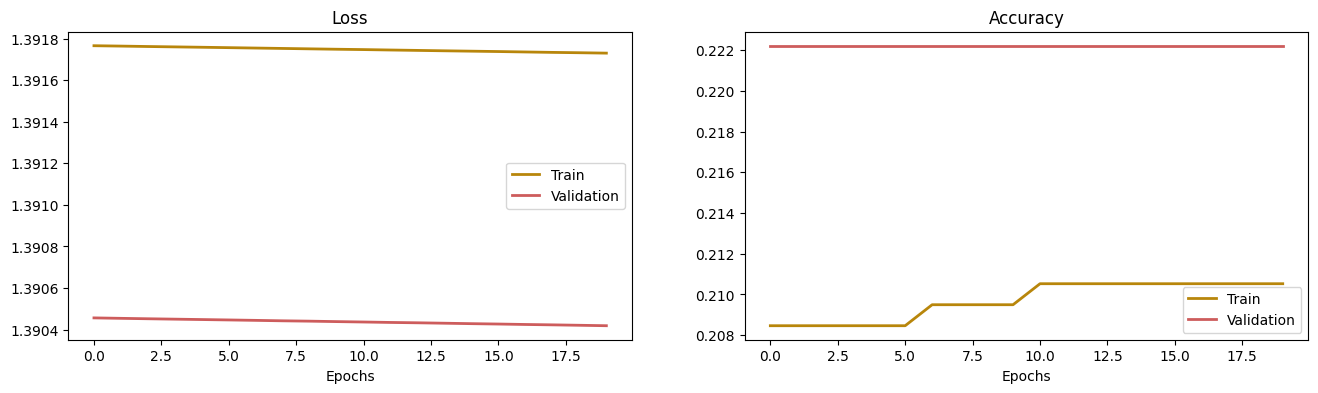

In [359]:
# YOUR CODE HERE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
def build_model(num_features, learning_rate):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)


  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()

    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))


    # create output layer
    model.add(keras.layers.Dense(
          units=4,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remember it's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

# Build a model
model_tf = build_model(num_features=len(features),learning_rate=0.00001)
model_tf.summary()

tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model_tf.fit(x=X_train,
                y=Y_train,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train),
                epochs=20,
                verbose=0 #silence fit
)

# Show learned model
w = model_tf.layers[0].get_weights()[0]
b = model_tf.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

---
### Step 6: Hyperparameter tuning

### <span style="color:chocolate">Exercise 8:</span> Choosing hyperparameters (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [360]:
learning_rate = 0.01
num_features = X_train.shape[1]
epoch = 20

model_tf = build_model(num_features = num_features, learning_rate=learning_rate)
y_preds = model_tf.predict(X_train)
history_tf = model_tf.fit(
  x = X_train,
  y = Y_train,
  epochs=epoch,
  validation_data=[X_val_std,Y_val],
  batch_size=16)

weights, bias = model_tf.layers[0].get_weights()
print(f'The first 5 parameters: \n {weights.flatten()[:5]} \n and basis {bias}.\n')

training_loss = history_tf.history['loss'][-1]
validation_loss = history_tf.history['val_loss'][-1]
print(f'Loss of tuned model on training dataset: {training_loss}')
print(f'Loss of tuned model on validation dataset: {validation_loss}')

loss_diff = abs((training_loss - validation_loss)/training_loss)
print(f'Percentage difference between the losses on the training and validation datasets: {loss_diff*100:}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4135 - loss: 1.3557 - val_accuracy: 0.4986 - val_loss: 1.2809
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5099 - loss: 1.2581 - val_accuracy: 0.4875 - val_loss: 1.2087
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5116 - loss: 1.1886 - val_accuracy: 0.4903 - val_loss: 1.1574
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5106 - loss: 1.1386 - val_accuracy: 0.4903 - val_loss: 1.1202
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 1.1019 - val_accuracy: 0.4903 - val_loss: 1.0929
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5115 - loss: 1.0744 - val_accuracy: 0.4819 - val_loss: 1.0723
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss: 1.0535 - val_accuracy: 0.4763 - val_loss: 1.0565
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss

---
### Step 7: Evaluation and generalization

### <span style="color:chocolate">Exercise 9:</span> Compute metrics (5 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [362]:
# YOUR CODE HERE

# Predict probabilities for training and validation datasets
train_preds_probs = model_tf.predict(X_train)
val_preds_probs = model_tf.predict(X_val)

# Converting predicted probabilities to class labels
train_preds_classes = np.argmax(train_preds_probs, axis=1)
val_preds_classes = np.argmax(val_preds_probs, axis=1)

# Calculating accuracy for training data
train_accuracy = np.mean(train_preds_classes == Y_train)
print(f'Aggregate Accuracy on Training Data: {train_accuracy}')

# Calculating accuracy for validation data
val_accuracy = np.mean(val_preds_classes == Y_val)
print(f'Aggregate Accuracy on Validation Data: {val_accuracy}')

'''The accuracy on both training and validation datasets are low and closer to each other. The model is underfitting. 
This shows that it has not learned the underlying patterns in the data well and thus performs poorly 
on both training and validation data.'''

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Aggregate Accuracy on Training Data: 0.5236768802228412
Aggregate Accuracy on Validation Data: 0.48467966573816157


'The accuracy on both training and validation datasets are low and closer to each other. The model is underfitting. \nThis shows that it has not learned the underlying patterns in the data well and thus performs poorly \non both training and validation data.'

### <span style="color:chocolate">Exercise 10:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


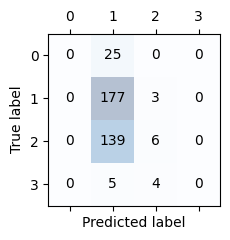

Class with the lowest precision: 0, Precision: 0.00
Class with the lowest recall: 0, Recall: 0.00
Class with the largest source of false positives: 1, False Positives: 169.0
Class with the largest source of false negatives: 2, False Negatives: 139.0


In [369]:
# YOUR CODE HERE
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()
    
y_test_pred_tf = model_tf.predict(x=X_test)
y_test_maxpred_tf =  np.argmax(y_test_pred_tf, axis=1)
conf_matrix = tf.math.confusion_matrix(
    Y_test,
    y_test_maxpred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

confusion_matrix_plot(conf_matrix.numpy())

'''Model confuses the class 2 the most. There were 139 instances of class 2 predicted as class 1'''



#confusion matrix
cm = confusion_matrix(Y_test, y_preds)

# Number of classes
num_classes = cm.shape[0]

# Initializing precision, recall, false positives, false negatives arrays
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
false_positives = np.zeros(num_classes)
false_negatives = np.zeros(num_classes)

# Calculate precision, recall, false positives, false negatives for each class
for i in range(num_classes):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    
    precision[i] = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
    false_positives[i] = FP
    false_negatives[i] = FN

# Identify the class with lowest precision and recall
lowest_precision_class = np.argmin(precision)
lowest_recall_class = np.argmin(recall)

# Identify the class with the highest false positives and false negatives
largest_fp_class = np.argmax(false_positives)
largest_fn_class = np.argmax(false_negatives)

print(f"Class with the lowest precision: {lowest_precision_class}, Precision: {precision[lowest_precision_class]:.2f}")
print(f"Class with the lowest recall: {lowest_recall_class}, Recall: {recall[lowest_recall_class]:.2f}")
print(f"Class with the largest source of false positives: {largest_fp_class}, False Positives: {false_positives[largest_fp_class]}")
print(f"Class with the largest source of false negatives: {largest_fn_class}, False Negatives: {false_negatives[largest_fn_class]}")


----
### <span style="color:chocolate">Bonus question</span> (20 points)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


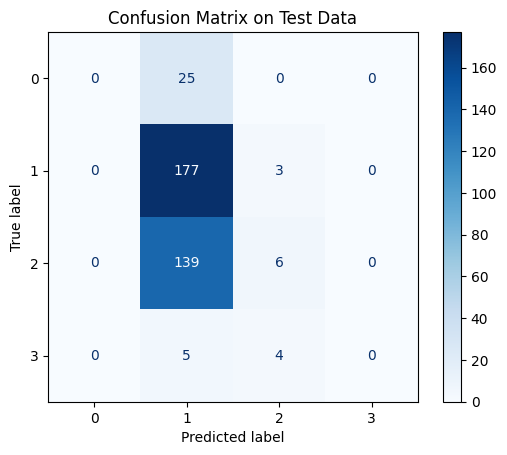

Class 0:
  True Positives (TP): 0
  False Positives (FP): 0
  False Negatives (FN): 25
  True Negatives (TN): 334
Class 1:
  True Positives (TP): 177
  False Positives (FP): 169
  False Negatives (FN): 3
  True Negatives (TN): 10
Class 2:
  True Positives (TP): 6
  False Positives (FP): 7
  False Negatives (FN): 139
  True Negatives (TN): 207
Class 3:
  True Positives (TP): 0
  False Positives (FP): 0
  False Negatives (FN): 9
  True Negatives (TN): 350


In [367]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predictions on the test data
y_preds_proba = model_tf.predict(X_test)

# Converting predicted probabilities to class labels using a threshold of 0.5
y_preds = np.argmax(y_preds_proba, axis=1)

#confusion matrix
cm = confusion_matrix(Y_test, y_preds)

# Plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

# Calculating True Positives, False Negatives, False Positives, True Negatives for each class
num_classes = cm.shape[0]
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  True Positives (TP): {TP[i]}")
    print(f"  False Positives (FP): {FP[i]}")
    print(f"  False Negatives (FN): {FN[i]}")
    print(f"  True Negatives (TN): {TN[i]}")
